In [1]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import plotly.express as px

2024-06-28 10:09:52.739366: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-28 10:09:55.015206: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def plot_images(images, title, n_rows=10, n_cols=10):
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
    plt.suptitle(title, fontsize=16)
    for i, image in enumerate(images[:n_rows * n_cols]):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(image.reshape(28, 28), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [3]:
data_dir = '../../data'

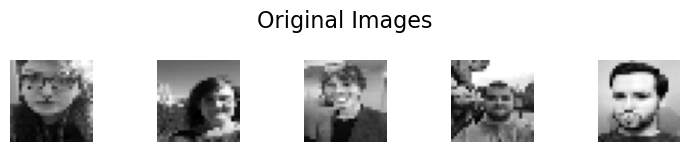

In [4]:
def load_image_data(data_dir, img_size=(28, 28)):
    labels = ['portrait', 'other']
    data = []
    for label in labels:
        folder_path = os.path.join(data_dir, label)
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path, target_size=img_size, color_mode='grayscale')
            img_array = img_to_array(img).astype('float32') / 255.0
            data.append(img_array.flatten())
    return np.array(data)

data = load_image_data(data_dir)
plot_images(data, title='Original Images', n_rows=1, n_cols=5)


In [5]:
max_iter = 10000
n_clusters = 1000
noise_level = 0.1
n_images = 10

In [6]:
class KMeansCustom:
    def __init__(self, data, n_clusters, max_iter):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.num_examples, self.num_features = data.shape
        self.plot_figure = True
        self.centroids = None  

# Initialisation centroides
    def initialize_random_centroids(self, X):
        centroids = np.zeros((self.n_clusters, self.num_features))  
        for i in range(self.n_clusters): 
            centroid = X[np.random.choice(range(self.num_examples))] 
            centroids[i] = centroid
        return centroids

# Calcul distance points / Centroides et affectation des points aux clusters
    def create_cluster(self, X, centroids): 
        clusters = [[] for _ in range(self.n_clusters)]
        for point_idx, point in enumerate(X):
            closest_centroid = np.argmin(
                np.sqrt(np.sum((point - centroids) ** 2, axis=1))
            )
            clusters[closest_centroid].append(point_idx)
        return clusters

# Calcul des nouveaux centroides (moyenne des points de chaque cluster)
    def calculate_new_centroids(self, clusters, X):
        centroids = np.zeros((self.n_clusters, self.num_features))  
        for idx, cluster in enumerate(clusters):
            new_centroid = np.mean(X[cluster], axis=0)  
            centroids[idx] = new_centroid
        return centroids

    def predict_cluster(self, clusters, X):
        y_pred = np.zeros(self.num_examples) 
        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                y_pred[sample_idx] = cluster_idx
        return y_pred

    def plot_fig(self, X, y):
        fig = px.scatter(X[:, 0], X[:, 1], color=y)
        fig.show()

    def fit(self, X):
        self.centroids = self.initialize_random_centroids(X)  
        for _ in range(self.max_iter):
            clusters = self.create_cluster(X, self.centroids)
            previous_centroids = self.centroids
            self.centroids = self.calculate_new_centroids(clusters, X) 
            diff = self.centroids - previous_centroids 
            if not diff.any():
                break
        y_pred = self.predict_cluster(clusters, X) 
        if self.plot_figure:  
            self.plot_fig(X, y_pred)   
        return y_pred

In [7]:
def train_kmeans(data, n_clusters, max_iter):
    kmeans = KMeansCustom(data, n_clusters=n_clusters, max_iter=max_iter)
    kmeans.fit(data)
    return kmeans

kmeans_model = train_kmeans(data, n_clusters, max_iter)


/home/kura/miniconda3/envs/UDL/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kura/miniconda3/envs/UDL/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


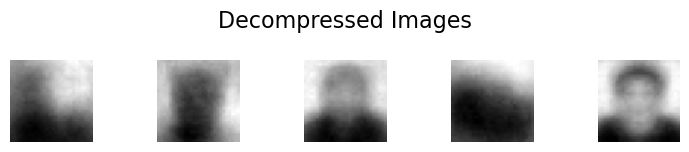

In [ ]:
def compress(data, kmeans_model):
    clusters = kmeans_model.create_cluster(data, kmeans_model.centroids)
    compressed_data = kmeans_model.predict_cluster(clusters, data)
    return compressed_data

# Transformer chaque point par le centroide de son cluster
def decompress(compressed_data, kmeans_model):
    decompressed_data = kmeans_model.centroids[compressed_data.astype(int)]
    return decompressed_data


compressed_data = compress(data, kmeans_model)
decompressed_data = decompress(compressed_data, kmeans_model)

plot_images(decompressed_data, title='Decompressed Images', n_rows=1, n_cols=5)

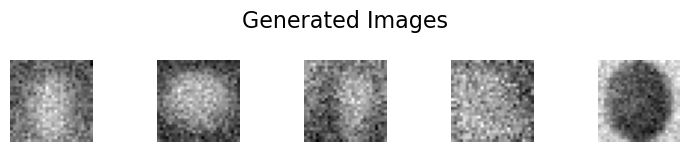

In [ ]:
# Use un représentant, ajout d'un bruit gaussien
def generate_new_images(kmeans_model, num_images):
    new_images = []
    for _ in range(num_images):
        centroid = kmeans_model.centroids[np.random.choice(range(kmeans_model.n_clusters))]
        new_image = centroid + np.random.uniform(scale=0.1, size=centroid.shape)
        new_images.append(new_image)
    return np.array(new_images)

new_images = generate_new_images(kmeans_model, num_images=5)
plot_images(new_images, title='Generated Images', n_rows=1, n_cols=5)